In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms


import numpy as np
import matplotlib.pyplot as plt


import time

### Dataset Loading and Transformation

In [2]:
# Transforms defined for the train, validation, and test datasets
train_transform = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.ToTensor()])

val_transform = transforms.Compose([transforms.Resize((256,256)),
                                   transforms.ToTensor()])


In [3]:
dir = 'Label_Data_TrainTest/'
train_dir, val_dir = dir+'train', dir+'val'
batch_size = 32
num_workers = 2

# Datasets extracted from their respective directories and some transformation applied to them
train_set = datasets.ImageFolder(train_dir, transform = train_transform)
val_set = datasets.ImageFolder(val_dir, transform = val_transform)



# Datasets loaded onto iterable object in form of batches 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle=True, num_workers=num_workers)



### Load all the finetuned base models

In [4]:
# For resnet152()

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

from torchvision import models
model_resnet152 = models.resnet152(pretrained=False)

model_resnet152.fc = nn.Linear(model_resnet152.fc.in_features, len(train_set.classes))

# Loading the state dict into our model
state_dict = torch.load('ResNet_4000Iterations.pth', map_location=device)
model_resnet152.load_state_dict(state_dict)


<All keys matched successfully>

In [5]:
# For vgg19()

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

from torchvision import models
model_vgg19 = models.vgg19(pretrained=False)


model_vgg19.classifier[-1] = nn.Linear(in_features=model_vgg19.classifier[-1].in_features, out_features=len(train_set.classes))



# Loading the state dict into our model
state_dict = torch.load('vgg19_4000Iterations.pth',map_location=device)

model_vgg19.load_state_dict(state_dict)



<All keys matched successfully>

In [6]:
# For densenet161()

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

from torchvision import models
model_densenet161 = models.densenet161(pretrained=False)


model_densenet161.classifier = nn.Linear(in_features=model_densenet161.classifier.in_features, out_features=len(train_set.classes))



# Loading the state dict into our model
state_dict = torch.load('densenet161_4000Iterations.pth',map_location=device)

model_densenet161.load_state_dict(state_dict)



<All keys matched successfully>

### Build ensemble model and evaluate its performance on the test dataset


Total number of correct predictions in batch number #1: 31/32
Correct Label: ['Gucci']
Wrongly Predicted Labels: ['Other']


Total number of correct predictions in batch number #2: 31/32
Correct Label: ['Emporio Armani']
Wrongly Predicted Labels: ['Giorgio Armani']


Total number of correct predictions in batch number #3: 32/32
Correct Label: []
Wrongly Predicted Labels: []


Total number of correct predictions in batch number #4: 31/32
Correct Label: ['Emporio Armani']
Wrongly Predicted Labels: ['Giorgio Armani']


Total number of correct predictions in batch number #5: 30/32
Correct Label: ['Gucci', 'Versace']
Wrongly Predicted Labels: ['Dior', 'Emporio Armani']


Total number of correct predictions in batch number #6: 32/32
Correct Label: []
Wrongly Predicted Labels: []


Total number of correct predictions in batch number #7: 32/32
Correct Label: []
Wrongly Predicted Labels: []


Total number of correct predictions in batch number #8: 30/32
Correct Label: ['Dior', 'Dior']
Wrongly 

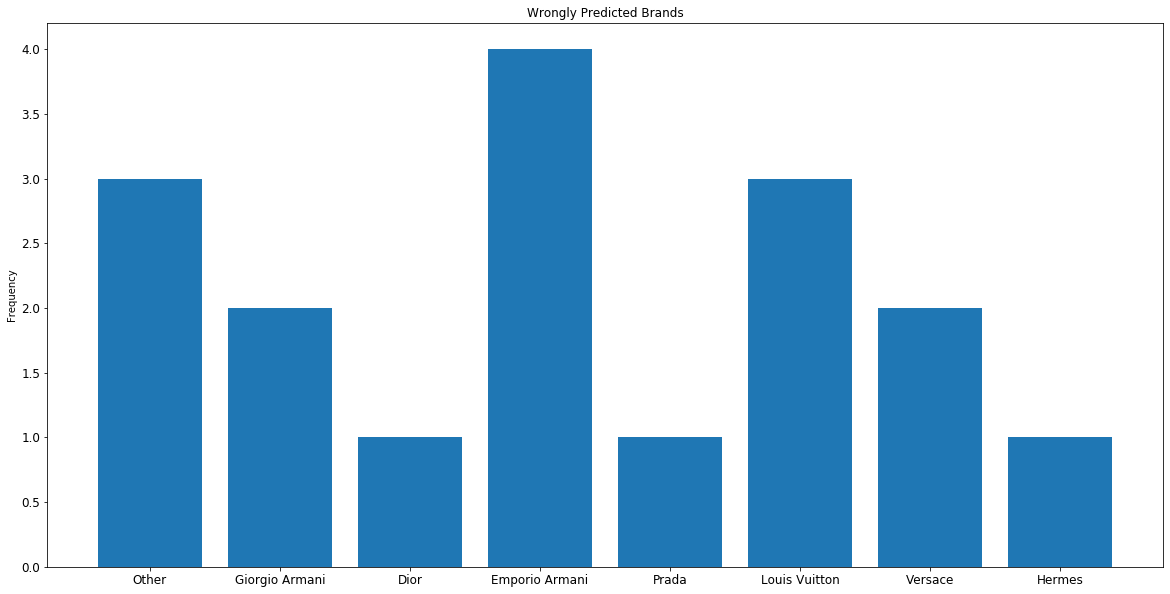

In [8]:
# Checking out the prediction on the validation set
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model_vgg19.to(device)
model_resnet152.to(device)
model_densenet161.to(device)

model_vgg19.eval()
model_resnet152.eval()
model_densenet161.eval()

with torch.no_grad():
    correct  = 0
    total = 0
    val_batch=0
    
    wrong_total = []
    

    for images_val, labels_val in val_loader:
        
        val_batch +=1
        
        images_val, labels_val = images_val.to(device), labels_val.to(device)
        
        
        
        outputs_resnet152 = model_resnet152(images_val)
        outputs_resnet152_n= outputs_resnet152/torch.norm(outputs_resnet152, p=1, dim=1).view(len(images_val), 1)
        
        
        outputs_vgg19 = model_vgg19(images_val)
        outputs_vgg19_n= outputs_vgg19/torch.norm(outputs_vgg19, p=1, dim=1).view(len(images_val), 1)
        
        outputs_densenet161 = model_densenet161(images_val)
        outputs_densenet161_n= outputs_densenet161/torch.norm(outputs_densenet161, p=1, dim=1).view(len(images_val), 1)
        
#         outputs = outputs_resnet152+outputs_vgg19+outputs_densenet161

        outputs_n = outputs_resnet152_n+outputs_vgg19_n+outputs_densenet161_n
        
    
        _,predicted = torch.max(outputs_n, 1)
        
        
        total += labels_val.size(0)
        correct += (predicted == labels_val).sum().item()
        
        
        # Check how many correct predictions are made in each each batch of the validation dataset
        print('\nTotal number of correct predictions in batch number #{}: {}/{}'.format(val_batch, (predicted == labels_val).sum().item(), len(images_val)))
        
        # Implementation to extract the wrongly predicted classes
        bool = (labels_val == predicted)
        index = [ind for ind, val in enumerate(bool) if not val]
        correct_val = labels_val[index]
        wrong_val = predicted[index]
        wrong_labels = [val_set.classes[x] for x in wrong_val]
        correct_labels = [val_set.classes[x] for x in correct_val]
        print('Correct Label:', correct_labels)
        print('Wrongly Predicted Labels:', wrong_labels)
        wrong_total.append(wrong_labels)
                
        print('='*100,'\n')
        
    print('Validation Accuracy: {:.2f}%'.format(correct/total*100))
    
    
    # Flatten the list wrong_total
    wrong_total =[item for sublist in wrong_total for item in sublist]
    
    import collections
    
    BarData = collections.Counter(wrong_total)
    wrong_brands = BarData.keys()
    freq = BarData.values()
    
    plt.figure(figsize = (20,10))
    plt.bar(wrong_brands, freq)
    plt.title('Wrongly Predicted Brands')
    plt.ylabel('Frequency')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)